In [156]:
## imports
import pandas as pd
import ceseek as ce
import os
import torch
import tangermeme
from itertools import product
import math

gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu


device(type='cuda')

In [12]:
## load high activity library
high_activity_dev = pd.read_csv('/grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_Library_CEseek/high_activity_dev.csv')
high_activity_hk = pd.read_csv('/grid/wsbs/home_norepl/pmantill/train_EvoAug/EvoAug_Library_CEseek/high_activity_hk.csv')

high_activity_dev.head()

,sequence,actual_dev,pred_dev,se_dev
0,TTTGACTAAAAAATATTCAAAATATAAACCAAACCAAACAACAAGC...,8.481741,6.143590,5.466950
1,CAGTTCAACTCACTTTTTGTAATATATATATATTTGGTTAATAAAA...,8.481741,5.618230,8.199696
2,TGAATTCAATATCCAAACACTTAATCTAAACTATTTTGTTGTTTAA...,7.993373,3.993589,15.998274
3,CTGATTTCCGAGATGGCCTTATCAAGCCGCTTTATCAGCATCTGTT...,7.993373,3.941199,16.420110
4,GAACCGAAGCGAAACGTGGCACGAAGCAGCCAAGTTGCAGTGAATC...,7.901251,2.372929,30.562347


In [13]:
high_activity_dev.head()

,sequence,actual_dev,pred_dev,se_dev
0,TTTGACTAAAAAATATTCAAAATATAAACCAAACCAAACAACAAGC...,8.481741,6.143590,5.466950
1,CAGTTCAACTCACTTTTTGTAATATATATATATTTGGTTAATAAAA...,8.481741,5.618230,8.199696
2,TGAATTCAATATCCAAACACTTAATCTAAACTATTTTGTTGTTTAA...,7.993373,3.993589,15.998274
3,CTGATTTCCGAGATGGCCTTATCAAGCCGCTTTATCAGCATCTGTT...,7.993373,3.941199,16.420110
4,GAACCGAAGCGAAACGTGGCACGAAGCAGCCAAGTTGCAGTGAATC...,7.901251,2.372929,30.562347


In [135]:
# Make control sequences - for each sequence in the high activity library, make 1 10x dishuffled sequence with tangermeme
def csv_to_fasta(csv_file, fasta_file, sequence_col='sequence', id_cols=None):
    """
    Convert CSV with sequences to FASTA format
    
    Args:
        csv_file: path to input CSV
        fasta_file: path to output FASTA
        sequence_col: name of column containing sequences
        id_cols: list of columns to include in FASTA header (optional)
    """
    df = pd.read_csv(csv_file)
    
    with open(fasta_file, 'w') as f:
        for idx, row in df.iterrows():
            # Create header - use index if no id_cols specified
            if id_cols:
                header_parts = [f"{col}={row[col]}" for col in id_cols if col in df.columns]
                header = f">seq_{idx}_" + "_".join(header_parts)
            else:
                header = f">seq_{idx}"
            
            # Write FASTA entry
            f.write(f"{header}\n{row[sequence_col]}\n")
            

def make_control_sequences(df, output_file, n=10):
    from tangermeme.ersatz import dinucleotide_shuffle
    from tangermeme.utils import one_hot_encode
    from tangermeme.utils import characters
    import torch
    
    sequences = df['sequence'].tolist()
    
    with open(output_file, 'w') as f:
        for orig_idx, seq in enumerate(sequences):
            # Convert single sequence to one-hot: shape (4, seq_len)
            one_hot = one_hot_encode(seq)
            
            # Add batch dimension for dinucleotide_shuffle: shape (1, 4, seq_len)
            one_hot_batch = one_hot.unsqueeze(0)
            
            # Generate n shuffled versions: returns shape (1, 4*n, seq_len)
            shuffled_batch = dinucleotide_shuffle(one_hot_batch, n=n, random_state=None)
            
            # Remove batch dimension and reshape: (4*n, seq_len) -> (n, 4, seq_len)
            shuffled_no_batch = shuffled_batch.squeeze(0)  # (4*n, seq_len)
            shuffled_reshaped = shuffled_no_batch.view(n, 4, -1)  # (n, 4, seq_len)
            
            # Convert each shuffled sequence to string
            for shuffle_num in range(n):
                # Extract single shuffled sequence: shape (4, seq_len)
                shuffled_seq_tensor = shuffled_reshaped[shuffle_num]
                
                # Convert to string using characters function
                shuffled_seq_str = characters(shuffled_seq_tensor)
                
                # Write to file
                f.write(f">shuffle_{orig_idx}_{shuffle_num}\n{shuffled_seq_str}\n")

In [138]:
# Get target and control sequences in fasta format

if not os.path.exists('high_activity_dev_with_scores.fasta'):
    # Include metadata in headers
    csv_to_fasta('high_activity_dev.csv', 'high_activity_dev_with_scores.fasta', 
        id_cols=['actual_dev', 'pred_dev', 'se_dev'])
        
if not os.path.exists('high_activity_hk_with_scores.fasta'):
    csv_to_fasta('high_activity_hk.csv', 'high_activity_hk_with_scores.fasta', 
        id_cols=['actual_hk', 'pred_hk', 'se_hk'])

if not os.path.exists('high_activity_dev_control.fasta'):
    make_control_sequences(high_activity_dev, output_file='high_activity_dev_control.fasta', n=10)

if not os.path.exists('high_activity_hk_control.fasta'):
    make_control_sequences(high_activity_hk, output_file='high_activity_hk_control.fasta', n=10)


#load fasta and print head to confirm
fasta_file_dev = 'high_activity_dev_with_scores.fasta'
fasta_file_hk = 'high_activity_hk_with_scores.fasta'
fasta_file_dev_control = 'high_activity_dev_control.fasta'
fasta_file_hk_control = 'high_activity_hk_control.fasta'

seq_count_dev = sum(1 for line in open(fasta_file_dev) if line.startswith('>'))
seq_count_hk = sum(1 for line in open(fasta_file_hk) if line.startswith('>'))

print(f"Number of sequences in {fasta_file_dev}: {seq_count_dev}, {high_activity_dev.shape[0]}")
print(f"Number of sequences in {fasta_file_hk}: {seq_count_hk}, {high_activity_hk.shape[0]}")

print(f'Control sequences length: {len(open(fasta_file_dev_control).readlines()) / 2}')
print(f'Control sequences length: {len(open(fasta_file_hk_control).readlines()) / 2}')

with open(fasta_file_dev_control, 'r') as f:
    print("")
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())
with open(fasta_file_hk_control, 'r') as f:
    print("")
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())



Number of sequences in high_activity_dev_with_scores.fasta: 5340, 5340
Number of sequences in high_activity_hk_with_scores.fasta: 3802, 3802
Control sequences length: 53400.0
Control sequences length: 38020.0

>shuffle_0_0

TATTTTTTAAGTTTATAACGTAAAATTTACGTGCAACGTTAACATCGTTTAATTTAATTCAAAGAAATGATGAATTACTTGAGCAATGGGCTTCCAACACTTGGAAAACATAGCCTTTTGTAACATAATACTTCTGTGACTTGACAAATTGCTATGATAAATTCGCATAGTGTTTAGTCGCCATTCTTTGCTTTGGACACTACATAAAGTTCCATTAAACAAGTACTCAAGATATAAGAGCAGAACCTG

>shuffle_0_1

TCAGACGATTCGTACAAGGTTAATATTAATTTTGTTGCTGTAGGACAAATAGTTTTGTCACAAGAATAGCTTACGTCTAAGATAACTCCTTCACAAATTTTTTGCAGCGCAAATAGCATAGTTTCAACCTTGCTAATATGAACAAACTTCTTGACAATGACACCGCATGTATATAAGTTTGATTTCTAAGAATGAAAACCTTGGTTATGGTAAAATTATATTGCTTTAAACAATTACCAAACGACTTTG


>shuffle_0_0

TGTGCGTCGACATTTATATAAAATTTGGGAGACGACATGATTATTAATAAACATTCGTAATTAGTCAGTTATCGGCGGGCGCTTTCTCCAATTGATGATAATTTCACGAAATTTTACTAGAATTGTTAAACAAAATAAAACGGATATCTTGTGTCTCTTTATTGATGATTTTCATGGGGAGAAACTAACATCGTTATAAAATTCGCATCCGGGTAGCATGGATGTTGCGAGTCGCATCAGATAAA

In [139]:
## Load CEseek motifs.pwm
pwm_file = 'DeepSTARR_dm6_motifs.pwm'

obj_dev = ce.CEseek(pwm_file)
obj_hk = ce.CEseek(pwm_file)

obj_dev.dict_motif.keys(), obj_hk.dict_motif.keys()

(odict_keys(['Jra', 'GATAe', 'CTCF', 'Atf6', 'CrebA', 'Max', 'twi', 'Dref']),
 odict_keys(['Jra', 'GATAe', 'CTCF', 'Atf6', 'CrebA', 'Max', 'twi', 'Dref']))

In [143]:
# load fasta into CEseek

obj_dev.load_sequences(fasta_file_dev, fasta_input=True, out_seq_len=249, sequence_set='target')
obj_hk.load_sequences(fasta_file_hk, fasta_input=True, out_seq_len=249, sequence_set='target')
obj_dev.load_sequences(fasta_file_dev_control, fasta_input=True, out_seq_len=249, sequence_set='control')
obj_hk.load_sequences(fasta_file_hk_control, fasta_input=True, out_seq_len=249, sequence_set='control')

obj_dev.scan_motifs(num_threads=8)
obj_hk.scan_motifs(num_threads=8)

len(obj_dev.sequences_control)/len(obj_dev.sequences), len(obj_hk.sequences_control)/len(obj_hk.sequences)



(10.0, 10.0)

In [ ]:
## Get tfmodisco working so we can confirm motifs
## Need tangermemes attribution methods on my student model
## Plot Control counts vs Target counts



In [168]:
# Run enrichment analysis to find significant CEs

def run_enrichment_analysis(obj):
    """Run enrichment analysis to find significant CEs"""
    print("=== Running Enrichment Analysis ===")
    
    motif_names = list(obj.dict_motif.keys())
    motif_pairs = list(product(motif_names, repeat=2))
    print(f"Analyzing {len(motif_pairs)} motif pairs...")
    
    # Store results for DataFrame
    results = []
    total_target = len(obj.sequences)
    total_control = len(obj.sequences_control)

    for i, (motif1, motif2) in enumerate(motif_pairs):
            
        target_counts = obj.count_CE_configuration_for_motif_pair(
            motif1, motif2, target_sequences=True, device='cuda'
        )
        control_counts = obj.count_CE_configuration_for_motif_pair(
            motif1, motif2, target_sequences=False, device='cuda'
        )

        for config_pair in target_counts.keys():
            for strand_pair in target_counts[config_pair].keys():
                for spacing, count_target in target_counts[config_pair][strand_pair].items():
                    count_control = control_counts[config_pair][strand_pair][spacing]

                    a = count_target
                    A = total_target
                    b = count_control
                    B = total_control

                    p_val = obj._fisher_exact_test_for_motif_hits(a, A, b, B)
                    log2_fc = math.log2(((count_target + 1e-9) / total_target) / ((count_control + 1e-9) / total_control))
                    # Only extract sequences for significant results with reasonable counts
                    if a > 0 and a>b:
                        results.append({
                            'motif1': motif1,
                            'motif2': motif2,
                            'config_pair': config_pair,
                            'strand_pair': strand_pair,
                            'spacing': spacing,
                            'ce_count_target': count_target,
                            'ce_count_control': count_control,
                            'p_value': p_val,
                            'log2_fc': log2_fc
                        })

    print(f"Found {len(results)} CE configurations")
    return results

    

In [169]:
dev_results = run_enrichment_analysis(obj_dev)
hk_results = run_enrichment_analysis(obj_hk)

dev_results_df = pd.DataFrame(dev_results)
hk_results_df = pd.DataFrame(hk_results)



=== Running Enrichment Analysis ===
Analyzing 64 motif pairs...
Found 314 CE configurations
=== Running Enrichment Analysis ===
Analyzing 64 motif pairs...
Found 246 CE configurations


In [ ]:
# Standardize names with CEseek fucntion !!!!!

426

In [172]:
dev_results_df.sort_values('ce_count_target', ascending=False).head(10)

,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc
233,Dref,GATAe,"(Dref, GATAe)","(+, +)",-5,172,98,2.452549e-109,4.133483
92,GATAe,Dref,"(Dref, GATAe)","(+, +)",-5,172,98,2.452549e-109,4.133483
295,Dref,Dref,"(Dref, Dref)","(-, +)",1,44,2,1.104818e-43,7.781360
297,Dref,Dref,"(Dref, Dref)","(-, +)",4,36,4,1.837532e-33,6.491853
202,twi,twi,"(twi, twi)","(+, +)",1,34,2,1.864658e-33,7.409391
215,twi,twi,"(twi, twi)","(-, -)",1,34,6,7.866893e-30,5.824428
293,Dref,Dref,"(Dref, Dref)","(+, -)",0,32,0,4.351945e-34,38.219281
299,Dref,Dref,"(Dref, Dref)","(-, +)",9,28,0,6.501370e-30,38.026636
307,Dref,Dref,"(Dref, Dref)","(-, -)",4,28,2,2.355599e-27,7.129283
279,Dref,Dref,"(Dref, Dref)","(+, +)",4,28,0,6.501370e-30,38.026636


In [175]:
hk_results_df.sort_values('ce_count_target', ascending=False).head(10)




,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc
145,Dref,GATAe,"(Dref, GATAe)","(+, +)",-5,368,67,7.453046e-314,5.779401
46,GATAe,Dref,"(Dref, GATAe)","(+, +)",-5,368,67,7.453046e-314,5.779401
26,GATAe,GATAe,"(GATAe, GATAe)","(-, +)",-2,104,12,3.103880e-94,6.437405
220,Dref,Dref,"(Dref, Dref)","(+, -)",0,52,4,1.300269e-49,7.022368
224,Dref,Dref,"(Dref, Dref)","(-, +)",-2,52,12,5.560645e-43,5.437405
228,Dref,Dref,"(Dref, Dref)","(-, +)",4,52,0,5.119186e-55,38.919721
226,Dref,Dref,"(Dref, Dref)","(-, +)",1,48,0,7.861041e-51,38.804243
204,Dref,Dref,"(Dref, Dref)","(+, +)",4,44,0,1.202471e-46,38.678713
239,Dref,Dref,"(Dref, Dref)","(-, -)",4,44,0,1.202471e-46,38.678713
231,Dref,Dref,"(Dref, Dref)","(-, +)",9,40,0,1.832260e-42,38.541209


In [ ]:
# Quick plots for motif enrichment analysis
import matplotlib.pyplot as plt
import numpy as np

def plot_motif_enrichment(results_df):
    # Assuming you have a results dataframe with columns: config_pair, strand_pair, spacing, log2_fc, p_value, ce_count_target, ce_count_control
    # Replace 'results_df' with your actual dataframe name

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Log2 Fold Change vs P-value (Volcano plot)
    ax1.scatter(results_df['log2_fc'], -np.log10(results_df['p_value']), alpha=0.6, s=50)   
    ax1.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')
    ax1.axvline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Log2 Fold Change')
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('Volcano Plot: Motif Enrichment')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Add labels for significant motifs
    significant = results_df[results_df['p_value'] < 0.05]
    for idx, row in significant.iterrows():
        if abs(row['log2_fc']) > 0.5:  # Only label if fold change > 1.4x
            ax1.annotate(row['config_pair'], (row['log2_fc'], -np.log10(row['p_value'])), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    # Plot 2: Target vs Control counts
    ax2.scatter(results_df['ce_count_target'], results_df['ce_count_control'], alpha=0.6, s=50)
    # Add diagonal line for equal counts
    max_count = max(results_df['ce_count_target'].max(), results_df['ce_count_control'].max())
    ax2.plot([0, max_count], [0, max_count], 'r--', alpha=0.5, label='Equal counts')
    ax2.set_xlabel('Target Count')
    ax2.set_ylabel('Control Count')
    ax2.set_title('Target vs Control Motif Counts')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Add labels for interesting motifs
    for idx, row in results_df.iterrows():
        if row['p_value'] < 0.01 and abs(row['log2_fc']) > 1:  # Significant and high fold change
            ax2.annotate(row['config_pair'], (row['ce_count_target'], row['ce_count_control']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Print some summary stats
    print(f"Total motifs analyzed: {len(results_df)}")
    print(f"Significant motifs (p<0.05): {sum(results_df['p_value'] < 0.05)}")
    print(f"Enriched in targets (log2_fc > 0): {sum(results_df['log2_fc'] > 0)}")
    print(f"Depleted in targets (log2_fc < 0): {sum(results_df['log2_fc'] < 0)}")
    print(f"High confidence (p<0.01, |log2_fc|>1): {sum((results_df['p_value'] < 0.01) & (abs(results_df['log2_fc']) > 1))}")


In [182]:
# Updated plotting function with configuration distribution
def plot_motif_enrichment_with_configs(results_df):
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Log2 Fold Change vs P-value (Volcano plot)
    ax1.scatter(results_df['log2_fc'], -np.log10(results_df['p_value']), alpha=0.6, s=50)
    ax1.axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')
    ax1.axvline(0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Log2 Fold Change')
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('Volcano Plot: Motif Enrichment')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2: Target vs Control counts
    ax2.scatter(results_df['ce_count_target'], results_df['ce_count_control'], alpha=0.6, s=50)
    max_count = max(results_df['ce_count_target'].max(), results_df['ce_count_control'].max())
    ax2.plot([0, max_count], [0, max_count], 'r--', alpha=0.5, label='Equal counts')
    ax2.set_xlabel('Target Count')
    ax2.set_ylabel('Control Count')
    ax2.set_title('Target vs Control Motif Counts')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Plot 3: Configuration frequency distribution
    if 'num_configs' in results_df.columns:
        config_counts = results_df['num_configs'].value_counts().sort_index()
        ax3.bar(config_counts.index, config_counts.values, alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Number of Configurations')
        ax3.set_ylabel('Number of Motif Pairs')
        ax3.set_title('Motif Pair Configuration Distribution')
        ax3.grid(alpha=0.3, axis='y')
        
        # Add statistics
        mean_configs = results_df['num_configs'].mean()
        median_configs = results_df['num_configs'].median()
        ax3.axvline(mean_configs, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_configs:.1f}')
        ax3.axvline(median_configs, color='orange', linestyle='--', alpha=0.7, label=f'Median: {median_configs:.1f}')
        ax3.legend()
        
        # Set x-axis range
        max_possible = 64  # Adjust based on your data
        ax3.set_xlim(0, min(max_possible, results_df['num_configs'].max() + 5))
        
        print(f"Configuration stats:")
        print(f"  Mean configs per motif pair: {mean_configs:.1f}")
        print(f"  Median configs per motif pair: {median_configs:.1f}")
        print(f"  Max configs found: {results_df['num_configs'].max()}")
        print(f"  Motif pairs with max configs: {sum(results_df['num_configs'] == results_df['num_configs'].max())}")
    else:
        ax3.text(0.5, 0.5, 'Configuration data not found\nAdd "num_configs" column to results_df', 
                 transform=ax3.transAxes, ha='center', va='center', fontsize=12)
        ax3.set_xlabel('Number of Configurations')
        ax3.set_ylabel('Number of Motif Pairs')
        ax3.set_title('Motif Pair Configuration Distribution')

    plt.tight_layout()
    plt.show()

    # Print summary stats
    print(f"Total motifs analyzed: {len(results_df)}")
    print(f"Significant motifs (p<0.05): {sum(results_df['p_value'] < 0.05)}")
    print(f"Enriched in targets (log2_fc > 0): {sum(results_df['log2_fc'] > 0)}")
    print(f"High confidence (p<0.01, |log2_fc|>1): {sum((results_df['p_value'] < 0.01) & (abs(results_df['log2_fc']) > 1))}")

# Use this function instead:
# plot_motif_enrichment_with_configs(your_results_df)


In [ ]:
# Function to add configuration counts to the dataframe
def add_config_counts(results_df, motif_pair_column='motif_pair'):
    """
    Add a 'num_configs' column that counts how many times each motif pair appears
    
    Parameters:
    results_df: DataFrame with motif pair results
    motif_pair_column: Name of the column containing motif pair identifiers
    
    Returns:
    DataFrame with added 'num_configs' column
    """
    # Count occurrences of each motif pair
    config_counts = results_df[motif_pair_column].value_counts()
    
    # Map the counts back to the original dataframe
    results_df['num_configs'] = results_df[motif_pair_column].map(config_counts)
    
    print(f"Configuration statistics:")
    print(f"  Total rows (configurations): {len(results_df)}")
    print(f"  Unique motif pairs: {len(config_counts)}")
    print(f"  Average configs per motif pair: {config_counts.mean():.2f}")
    print(f"  Max configs for any motif pair: {config_counts.max()}")
    print(f"  Motif pairs with only 1 config: {sum(config_counts == 1)}")
    print(f"  Motif pairs with >10 configs: {sum(config_counts > 10)}")
    
    return results_df


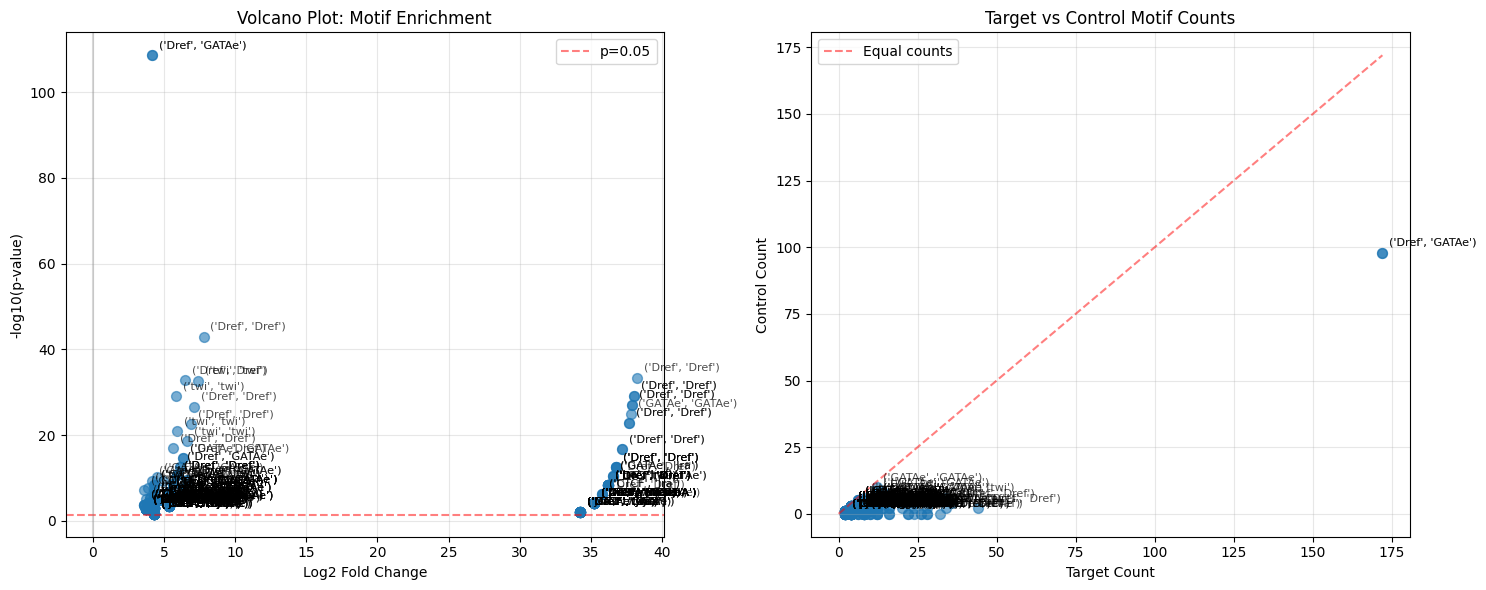

Total motifs analyzed: 314
Significant motifs (p<0.05): 314
Enriched in targets (log2_fc > 0): 314
Depleted in targets (log2_fc < 0): 0
High confidence (p<0.01, |log2_fc|>1): 278


In [181]:
plot_motif_enrichment(dev_results_df)

In [186]:
add_config_counts(dev_results_df,'config_pair')

Configuration statistics:
  Total rows (configurations): 314
  Unique motif pairs: 25
  Average configs per motif pair: 12.56
  Max configs for any motif pair: 42
  Motif pairs with only 1 config: 0
  Motif pairs with >10 configs: 11


,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc,num_configs
0,Jra,Jra,"(Jra, Jra)","(+, +)",6,4,2,8.803367e-04,4.321928,10
1,Jra,Jra,"(Jra, Jra)","(+, +)",2,4,2,8.803367e-04,4.321928,10
2,Jra,Jra,"(Jra, Jra)","(+, +)",0,4,0,6.823160e-05,35.219281,10
3,Jra,Jra,"(Jra, Jra)","(+, -)",9,4,0,6.823160e-05,35.219281,10
4,Jra,Jra,"(Jra, Jra)","(-, +)",1,8,0,4.642878e-09,36.219281,10
...,...,...,...,...,...,...,...,...,...,...
309,Dref,Dref,"(Dref, Dref)","(-, -)",2,4,0,6.823160e-05,35.219281,41
310,Dref,Dref,"(Dref, Dref)","(-, -)",1,22,0,1.181019e-23,37.678713,41
311,Dref,Dref,"(Dref, Dref)","(-, -)",0,26,0,7.938153e-28,37.919721,41
312,Dref,Dref,"(Dref, Dref)","(-, -)",-1,6,2,1.340808e-05,4.906891,41


In [189]:
dev_results_df.sort_values('num_configs', ascending=True).head(10)

,motif1,motif2,config_pair,strand_pair,spacing,ce_count_target,ce_count_control,p_value,log2_fc,num_configs
148,CrebA,CTCF,"(CTCF, CrebA)","(+, -)",-3,2,1,0.023287,4.321928,2
143,Atf6,CTCF,"(Atf6, CTCF)","(+, +)",-2,4,2,0.000880,4.321928,2
157,Max,GATAe,"(GATAe, Max)","(-, +)",-2,4,1,0.000316,5.321928,2
82,GATAe,Max,"(GATAe, Max)","(-, +)",-2,4,1,0.000316,5.321928,2
129,CTCF,CrebA,"(CTCF, CrebA)","(+, -)",-3,2,1,0.023287,4.321928,2
128,CTCF,Atf6,"(Atf6, CTCF)","(+, +)",-2,4,2,0.000880,4.321928,2
146,CrebA,GATAe,"(CrebA, GATAe)","(+, +)",1,4,1,0.000316,5.321928,4
145,Atf6,Dref,"(Atf6, Dref)","(-, -)",-5,4,2,0.000880,4.321928,4
144,Atf6,Dref,"(Atf6, Dref)","(+, -)",6,4,0,0.000068,35.219281,4
142,Atf6,GATAe,"(Atf6, GATAe)","(-, +)",5,4,2,0.000880,4.321928,4


Configuration stats:
  Mean configs per motif pair: 22.0
  Median configs per motif pair: 18.0
  Max configs found: 42
  Motif pairs with max configs: 42


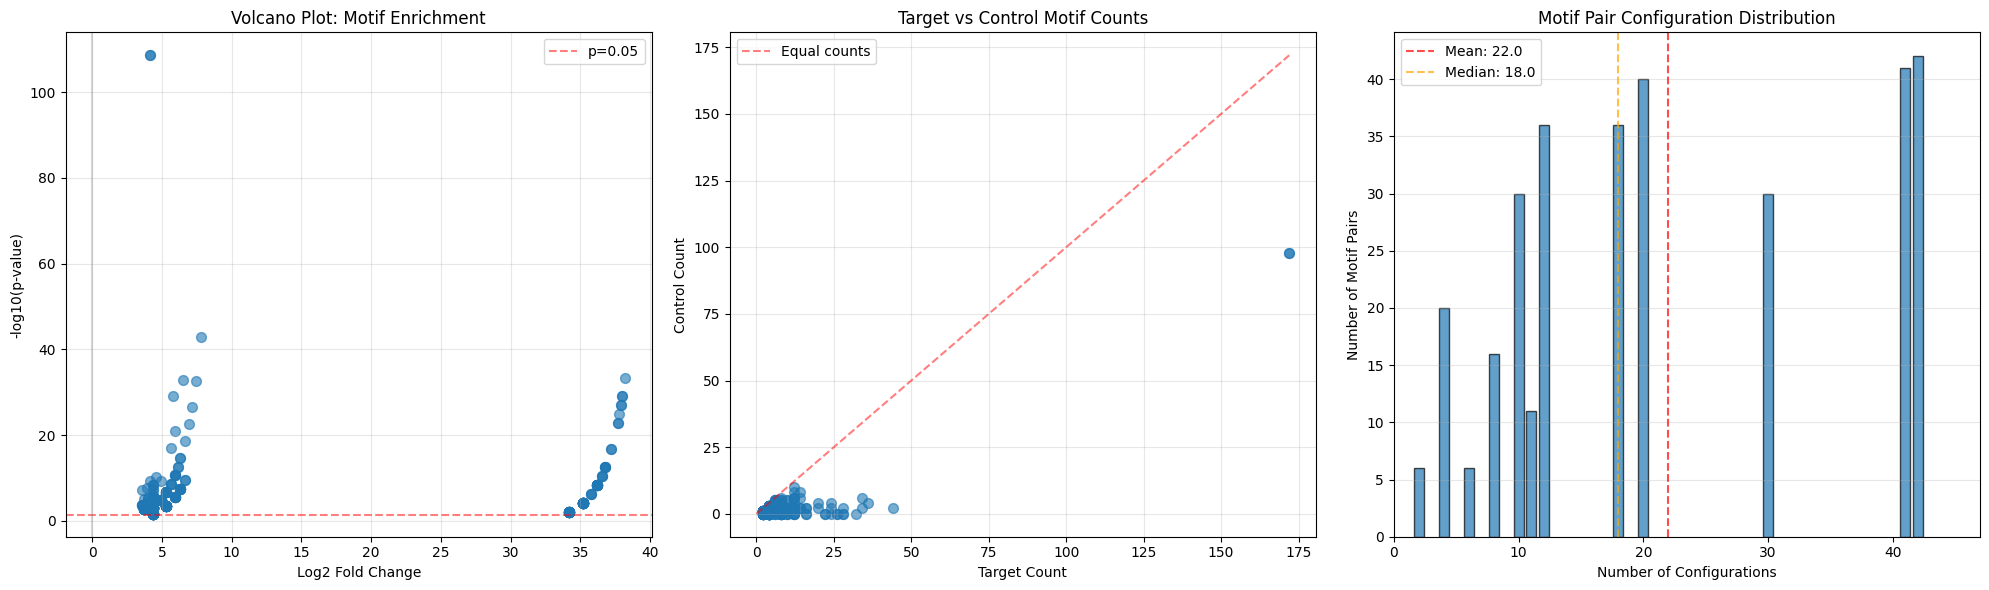

Total motifs analyzed: 314
Significant motifs (p<0.05): 314
Enriched in targets (log2_fc > 0): 314
High confidence (p<0.01, |log2_fc|>1): 278


In [187]:
plot_motif_enrichment_with_configs(dev_results_df)